Javier Alemán Rodríguez

# DengAI: Predicción de la propagación de enfermedades

## Extracción y transformación de datos

### Importación de librerías

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn.metrics
from scipy import cluster
from sklearn.preprocessing import LabelEncoder

In [4]:
url = 'https://raw.githubusercontent.com/JaviARo/Datasets/main/DengAI'

dengue_labels_train = pd.read_csv(f'{url}/dengue_labels_train.csv')
dengue_features_train = pd.read_csv(f'{url}/dengue_features_train.csv')
dengue_features_test = pd.read_csv(f'{url}/dengue_features_test.csv')

Posteriomente lo cargamos en un DataFrame de Pandas con el nombre de *bikes*

In [5]:
dengue_labels_train.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [6]:
dengue_features_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [7]:
dengue_features_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


## Limpieza de datos

In [9]:
def NumericalDataScalerAndFillNaN(df):
  # Selección de columnas numéricas
  numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

  preprocessor_RR = ColumnTransformer([('scale', MinMaxScaler(), numeric_cols)],remainder='passthrough')

  df[numeric_cols] = preprocessor_RR.fit_transform(df[numeric_cols])
  df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
  return df

def CategoricalToNumerical(df, categorical_cols): 
	le = LabelEncoder()

	for col in categorical_cols: 
		df[col] = le.fit_transform(df[col])    
	return df

In [13]:
X = dengue_features_train.drop(columns=["week_start_date"], axis=1)
X = CategoricalToNumerical(X, ["city"])
X = NumericalDataScalerAndFillNaN(X)
y = dengue_labels_train['total_cases']
X.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1,0.0,0.326923,0.578226,0.614835,0.386418,0.395544,0.031797,0.388291,0.354667,...,0.056091,0.381614,0.031797,0.262659,0.086660,0.430091,0.210393,0.174194,0.486239,0.029450
1,1,0.0,0.346154,0.629943,0.657063,0.321190,0.359233,0.058423,0.472710,0.441778,...,0.031446,0.479668,0.058423,0.418164,0.069133,0.565350,0.163498,0.322581,0.688073,0.015829
2,1,0.0,0.365385,0.479441,0.690881,0.311879,0.384430,0.088428,0.548064,0.496000,...,0.045749,0.594415,0.088428,0.586900,0.064265,0.565350,0.173638,0.354839,0.743119,0.076201
3,1,0.0,0.384615,0.584823,0.770066,0.438912,0.491150,0.039324,0.575260,0.539556,...,0.024365,0.552387,0.039324,0.566808,0.073028,0.645897,0.198986,0.425806,0.788991,0.007362
4,1,0.0,0.403846,0.658698,0.788882,0.481601,0.509943,0.019252,0.645515,0.593778,...,0.021385,0.555396,0.019252,0.628226,0.112950,0.802432,0.429658,0.535484,0.844037,0.010676


## Separación de variables de entrenamiento y test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## Selección de características

### SelectKBest

In [17]:
def ApplySelectKBest(X_train, X_test, y_train, k):
	selector = SelectKBest(f_regression, k=k)

	selector.fit_transform(X_train, y_train)
	selector.transform(X_test)

	print(f"Mejores {k} columnas = [")
	for col in selector.get_feature_names_out():
		print(f"  \'{col}\'")
	print("]\n")

In [18]:
ApplySelectKBest(X_train, X_test, y_train, k=5)
ApplySelectKBest(X_train, X_test, y_train, k=9)

Mejores 5 columnas = [
  'city'
  'year'
  'reanalysis_min_air_temp_k'
  'reanalysis_tdtr_k'
  'station_min_temp_c'
]

Mejores 9 columnas = [
  'city'
  'year'
  'weekofyear'
  'reanalysis_air_temp_k'
  'reanalysis_max_air_temp_k'
  'reanalysis_min_air_temp_k'
  'reanalysis_tdtr_k'
  'station_diur_temp_rng_c'
  'station_min_temp_c'
]



### Matriz de correlación

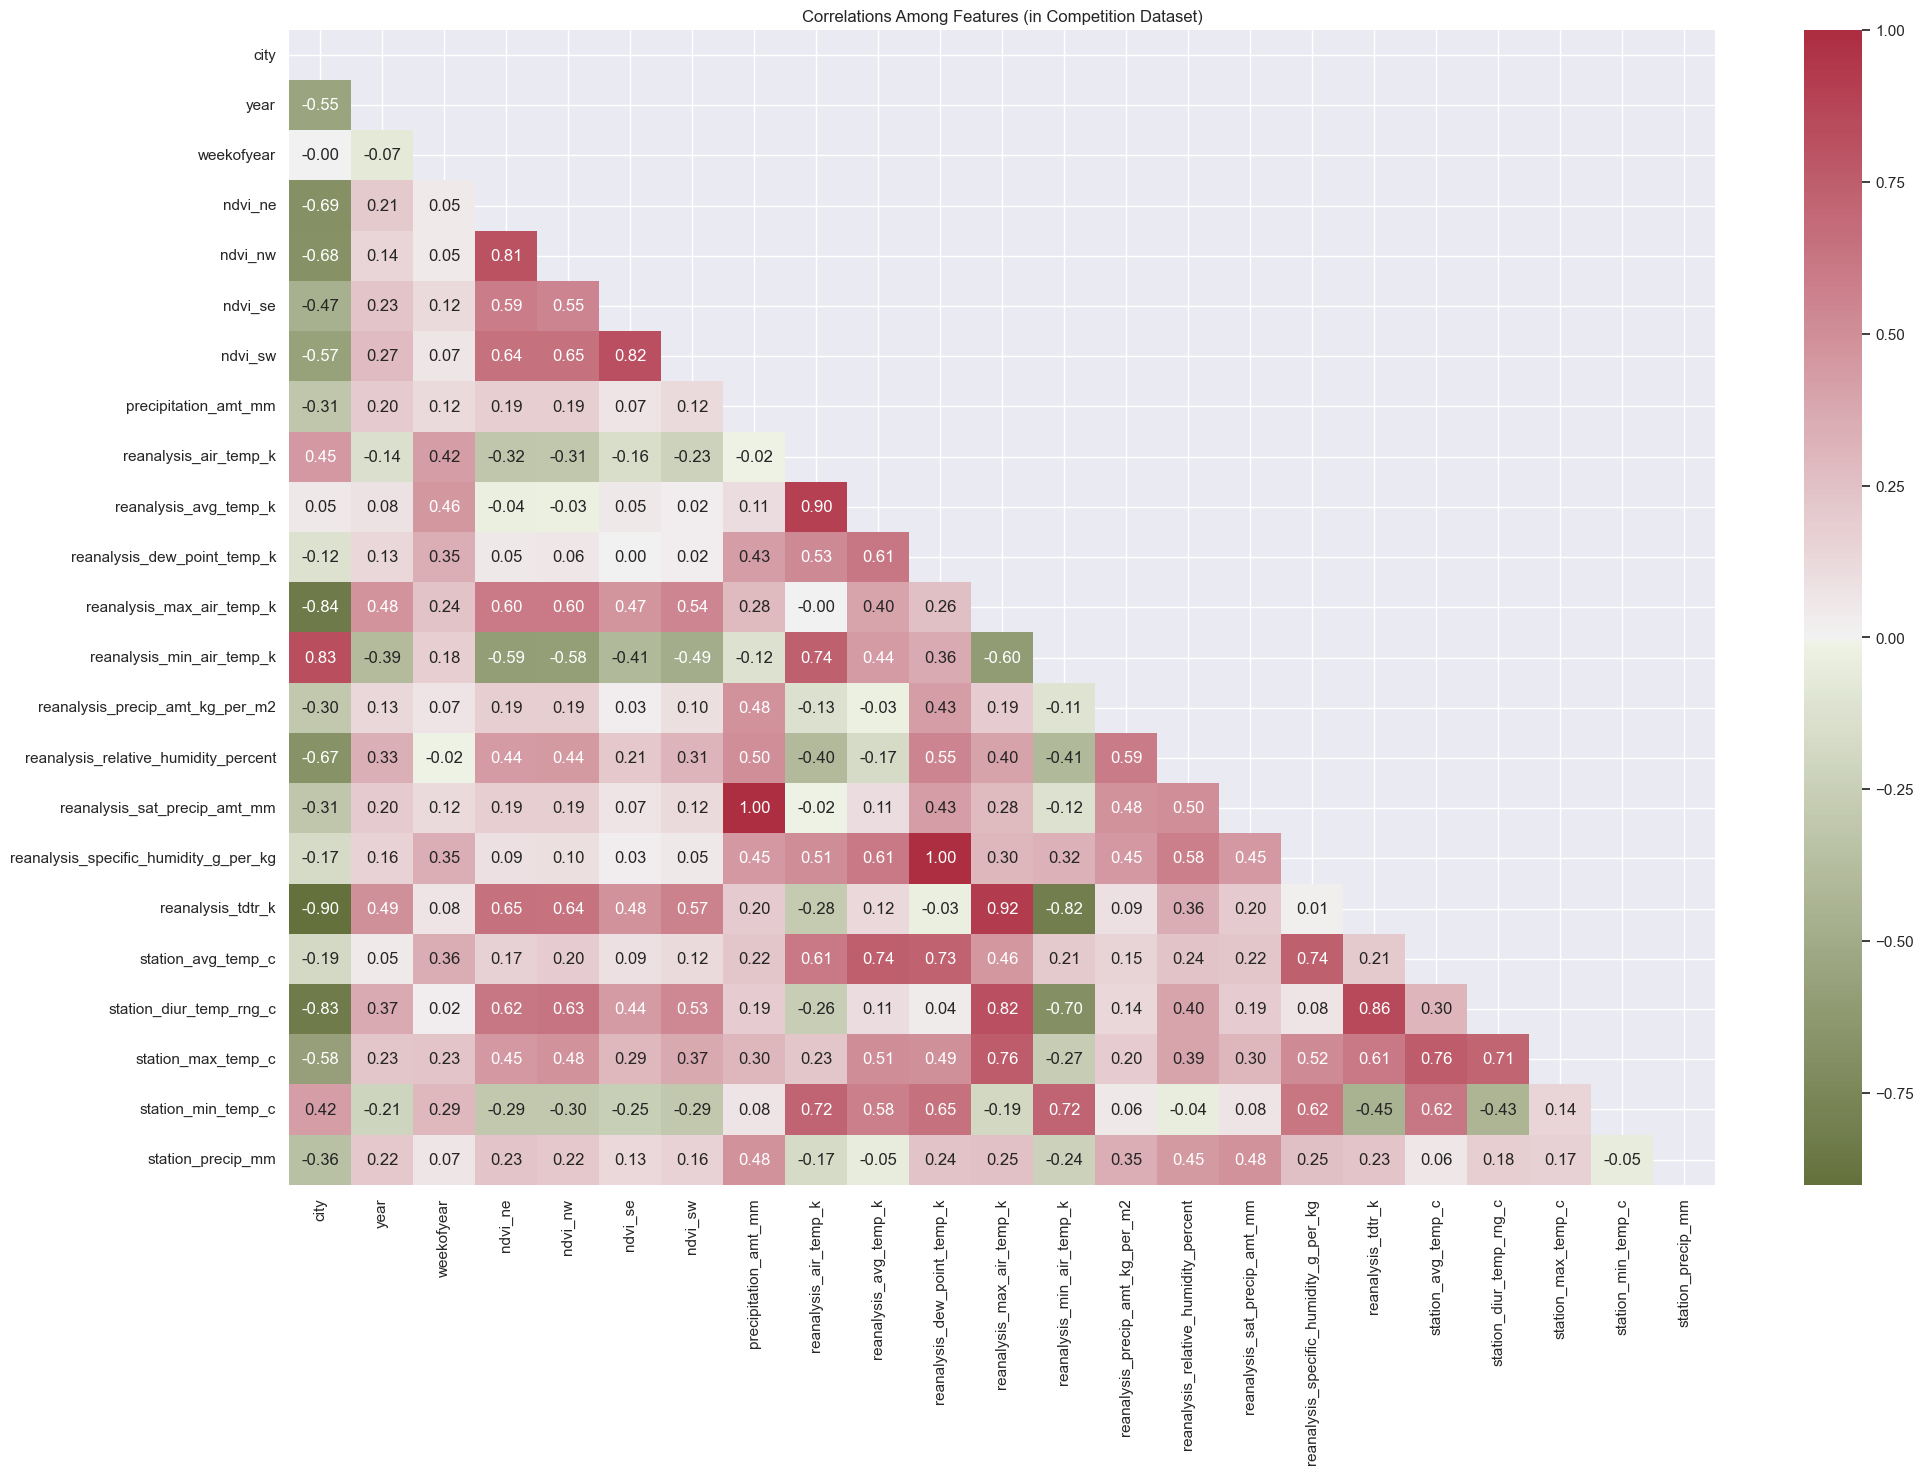

In [19]:
sns.set()

# Calcular la matriz de correlación
corr_mat_data = X.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool)) # Recorta la gráfica

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (23, 15))
# sns.heatmap(X.corr(), square=True, annot=True)
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)');

Las mayores correlaciones se dan entre las siguientes variables

Positivas:
*   reanalysis_sat_precip_amt_mm y precipitation_amt_mm: 1.00
*   reanalysis_specific_humidity_g_per_kg y reanalysis_dew_point_temp_k: 1.00



### Dendograma

Distancia Media	  13.06


C:\Users\redbe\AppData\Local\Temp\ipykernel_20024\857377492.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='complete')


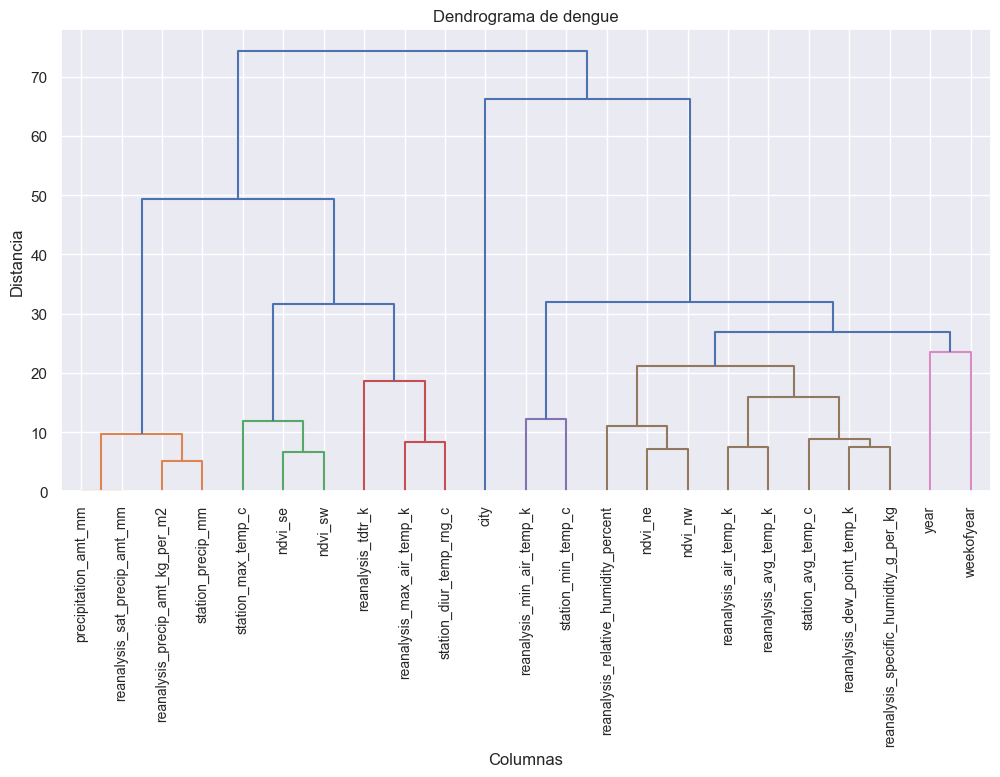

In [20]:
X_T = X.T

dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
D = dist.pairwise(X_T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

plt.figure(figsize=(12, 6))
plt.title('Dendrograma de dengue')
plt.xlabel('Columnas')
plt.ylabel('Distancia')
threshold_2 = 26

clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=threshold_2, labels=X.columns.to_list(), leaf_rotation=90)
plt.show()

Vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning/train) y otra para test. Para ello vamos a utilizar los datos de 2011 y la mitad de 2012 para entrenamiento y el resto de 2012 para los tests.  

In [ ]:
# Importante la función .to_html y display_html -> Muestra el contenido de un dataframe en formato HTML
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [ ]:
# 0.1 features and labels
df = bikes[['temperature', 'humidity', 'windspeed', 'count']]

train = df.loc['2011-01-01':'2011-12-31']
test  = df.loc['2012-01-01':]

display_side_by_side(train.tail(),test.head())



,temperature,humidity,windspeed,count
date,,,,
2011-12-27,9.105544,63.874550,17.145141,103.0
2011-12-28,7.820556,49.436222,24.671369,255.0
2011-12-29,5.297420,53.358888,12.220576,254.0
2011-12-30,8.443281,56.848605,13.285195,491.0
2011-12-31,6.435742,54.120804,17.410529,390.5
,temperature,humidity,windspeed,count
date,,,,
2012-01-01,4.428203,51.393004,21.535863,290.0
2012-01-02,2.420664,48.665204,25.661197,189.5


In [ ]:
train

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0
...,...,...,...,...
2011-12-27,9.105544,63.874550,17.145141,103.0
2011-12-28,7.820556,49.436222,24.671369,255.0
2011-12-29,5.297420,53.358888,12.220576,254.0


In [ ]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)


Vamos a graficar los datos de train

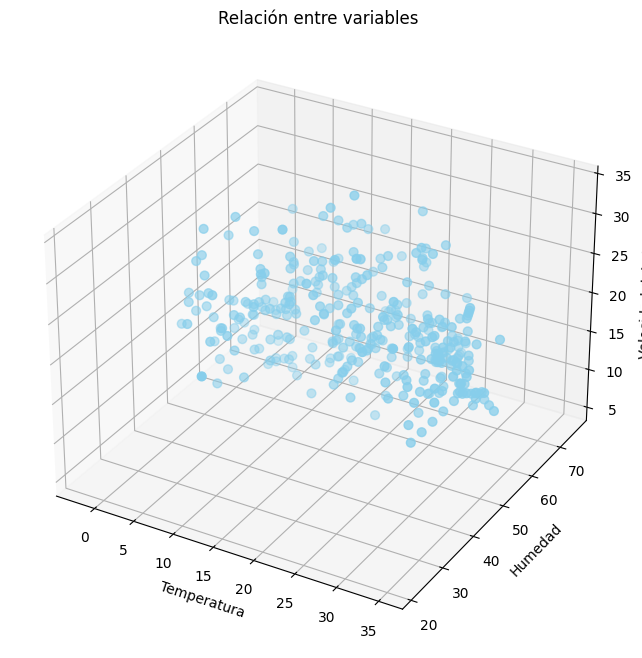

In [ ]:
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# La posición de los ejes es tal como se indica en el enlace superior.

# Título: Interpretar los resultados clave para Gráfica de dispersión 3D
# Url: https://support.minitab.com/es-mx/minitab/20/help-and-how-to/graphs/3d-scatterplot/interpret-the-results/key-results/

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[8,8])

ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['temperature'], train['humidity'], train['windspeed'], c='skyblue', s=40)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Humedad')
ax.set_zlabel('Velocidad del viento')
ax.set_title('Relación entre variables')
plt.show()


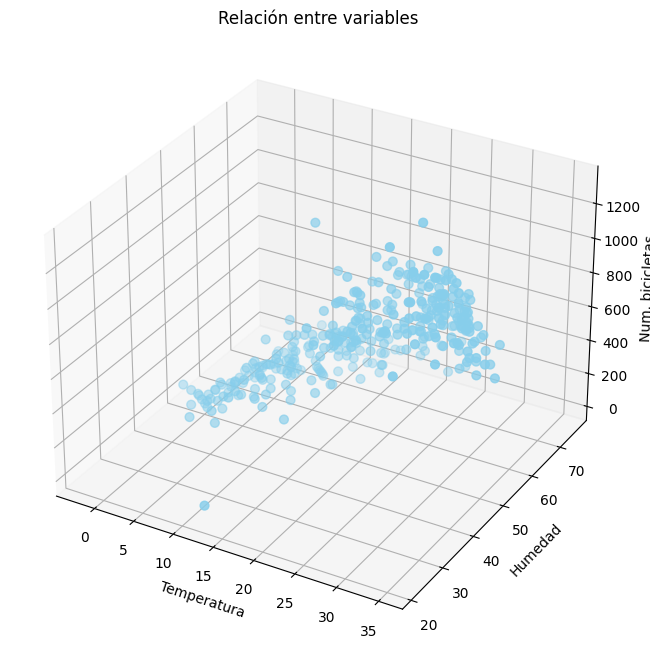

In [ ]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['temperature'], train['humidity'], train['count'], c='skyblue', s=40)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Humedad')
ax.set_zlabel('Num. bicicletas')
ax.set_title('Relación entre variables')

plt.show()

In [ ]:
#Ejer 01: 1.	En lugar de utilizar un gráfico 3D para ver la correlación de la variables, montar el código para mostrarlo por medio de una matriz de correlación
#           , pero excluyendo la columna count. Y comparar/comentar el resultado con las features_importance (indicado más adelante) que ha deducido el modelo.


#1. Parametrización

Existen diferentes parámetros que se pueden optimizar para la utilización de RandomForests,  en este caso vamos a ceñirnos a a optimizar el número de estimadores (números de árboles en el bosque) que vamos a probar con distintas potencias de 2


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit()

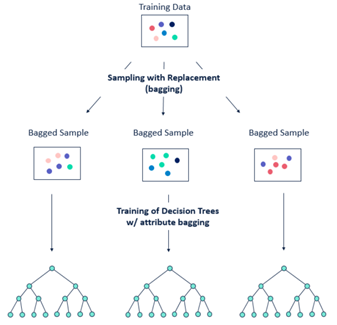

In [ ]:
from sklearn.ensemble import RandomForestRegressor # Utilizamos esta librería porque es un problema de regresión,
                                                   # corresponde al modelo comentado en la D25
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np


In [ ]:
# Vamos a representar en una gráfica el MAE en función del hiperparámetro n_estimator: número de árboles en el bosque
# consultar la ayuda conextual del modelo
#l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
l_estimators = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15,16,17,18,19,20]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   # Con el parámetro n_estimator se indica el número de árboles en el bosque
   # Recuerda que el parámetro criterioon es el criterio que se va a utilizar para medir la calidad de una división,
   #                                      es decir que las cosas que son similares deben estar juntas y las que son diferentes,
   #                                      deben separarse y distinguirse claramente unas de otras.
   #                                      Dependiendo del tipo de problema estos son los posibles valores:
   #                                             -> Clasificación: Gini, entropy
   #                                             -> Regresión: mse, mae, friedman, en la versión última (squared_error)
   # regressor =  RandomForestRegressor(n_estimators= estimators, criterion='mae', random_state=0)
   # En la nueva versión se sustituyó el error 'mae' por 'absolute_error', es equivalente
   regressor =  RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)

   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['count'], axis=1),
                           y = f_train['count'])
      y_pred = regressor.predict(X = f_test.drop(['count'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['count'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

print(total_scores)




[161.13111111111112, 157.21722222222223, 147.48148148148147, 150.84625, 149.79144444444447, 148.8449537037037, 147.64642857142854, 146.61013888888888, 148.1623765432099, 147.21733333333333, 148.55631313131312, 147.5895601851852, 146.37179487179486, 147.0224404761905, 145.9042962962963, 146.04362847222222, 146.9641176470588, 147.36368827160496, 148.63576023391812, 148.710375]


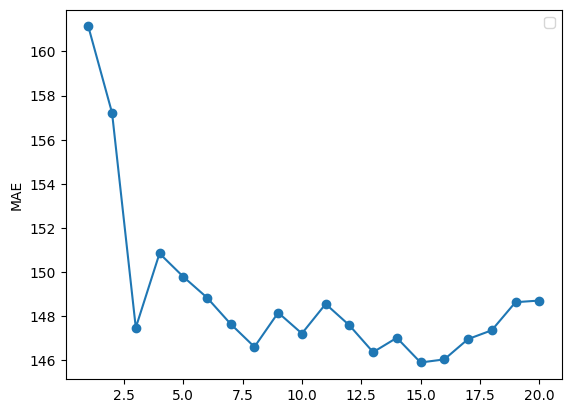

In [ ]:
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')


plt.legend()
plt.show()

In [ ]:
np.argmin(total_scores)

3

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 16, MAE = 146.04)


# 2. Construcción y ejecución del modelo



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', random_state=0)
# fit and predict


for train_fold, test_fold in cv.split(train):
  # División train test aleatoria
  f_train = train.loc[train_fold]
  f_test = train.loc[test_fold]
  # entrenamiento y ejecución del modelo
  regressor.fit( X = f_train.drop(['count'], axis=1),
                        y = f_train['count'])

# MUY INTERESANTE: Entrenar sin CV y observar la diferencia del MAE, realizando el train SIN cv y CON cv
#regressor.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = regressor.predict(X = test.drop(['count'], axis = 1))

Calculamos el mae obtenido. Cuando se trata de una competición esta línea la ejecuta la propia competición

In [ ]:
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)

MAE 247.18966302367943


Y guardamos el fichero de resultados en nuestro disco.

In [ ]:
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
# INTERESANTE: es una forma de comparar en una hoja de cálculo lo esperado (test) y lo predicho
output = pd.DataFrame({ 'date': test.index, 'result_predict': res, 'result_test': test['count']})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Por último, realizamos un gráfico para visualizar cómo ha quedado nuestra predicción con respecto a la realidad que se nos indica en el dataset.

In [ ]:
output

,date,result_predict,result_test
date,,,
2012-01-01,2012-01-01,96,290.000000
2012-01-02,2012-01-02,82,189.500000
2012-01-03,2012-01-03,73,89.000000
2012-01-04,2012-01-04,93,95.000000
2012-01-05,2012-01-05,184,140.000000
...,...,...,...
2012-12-27,2012-12-27,104,247.000000
2012-12-28,2012-12-28,118,644.000000
2012-12-29,2012-12-29,88,575.666667


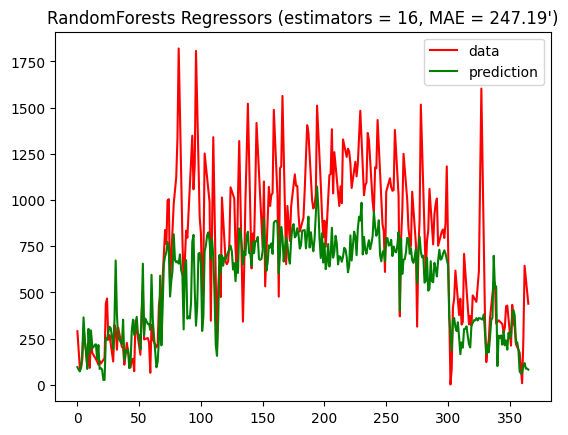

In [ ]:

from sklearn.metrics import mean_absolute_error

# x axis for plotting
import numpy as np
xx = np.arange(test['count'].shape[0])
plt.plot(xx, test['count'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [ ]:
# FEATURE RELEVANCIES
# Muy interesante porque podemos observar la relavancia de las características a la hora de entrenar el modelo.
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('temperature', 'humidity', 'windspeed') ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,temperature,0.675692
1,humidity,0.192387
2,windspeed,0.131921


## 3. Comparativa entre diferentes modelos de árboles para el mismo problema

In [ ]:
# Duda: ¿A qué tipo/técnica de árbol de los indicados en las diapos corresponden estos modelos?
# En las diapos (D22..D25) se habla de :
#      ->  Bagging(Bootstrap aggregation)
#      ->  Random forest : Este es el ejemplo de las celdas anteriores (RandomForestRegressor)
#      ->  Boosted Trees

from sklearn.tree import DecisionTreeRegressor # Este es un modelo de un arbol individual, es decir no se utiliz la técnica de dividir el datset en subárboles
                                               # (D7) - Lo vimos en el ejemplo_3_7
from sklearn.ensemble import AdaBoostRegressor # Este pertenece a los modelos tipo Boosting (D25)
from sklearn.ensemble import GradientBoostingRegressor # Este pertenece a los modelos tipo Boosting (D25)
from sklearn.ensemble import BaggingClassifier # Este pertenece a los modelos tipo Bagging (D23)

# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=6, criterion='absolute_error'))

# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=6, criterion='absolute_error'), n_estimators=128, random_state=0))

# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
regressors.append(GradientBoostingRegressor(n_estimators=50, learning_rate=0.25, random_state=0, loss='squared_error'))

# No utilizamos el algoritmo para los árboles tipo Bagging porque el data set de ejemplo es un problema de tipo de regresión con valores continuos
# y da error al ejecutarse
#
# En este otro artículo se muestra un ejemplo con un problema de clasificación:
# https://vitalflux.com/bagging-classifier-python-code-example/
#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
# regressors.append(BaggingClassifier(n_estimators=10, random_state=0))


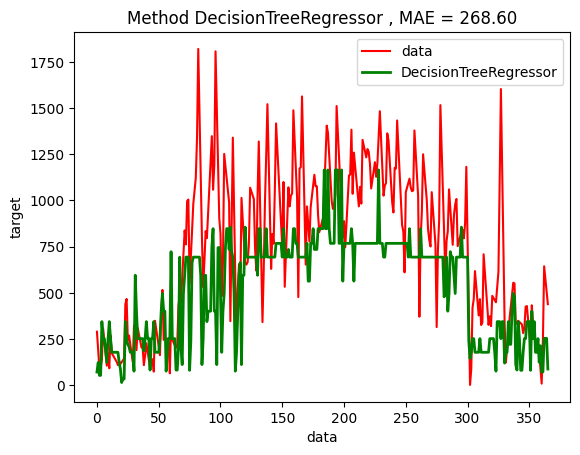

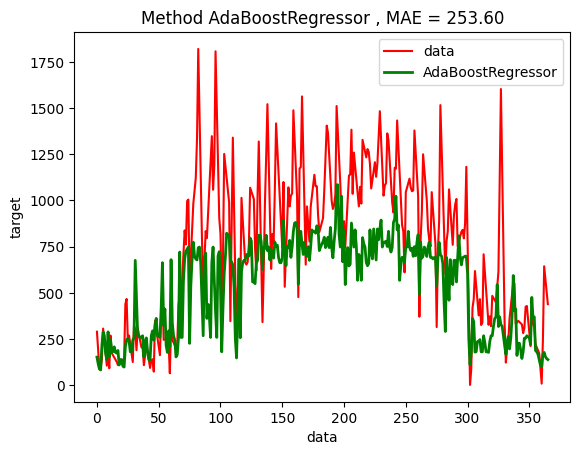

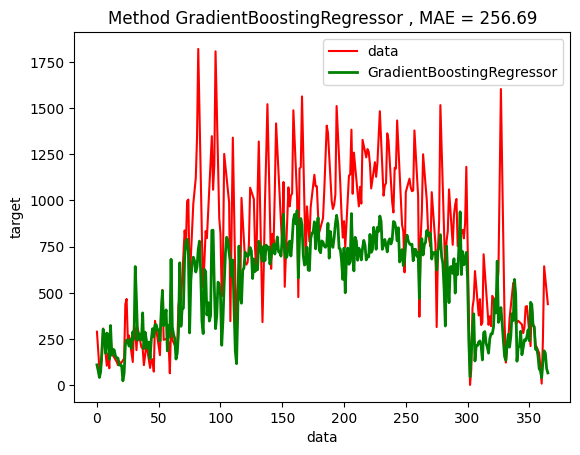

In [ ]:
# En la variable(array) xx guarda los valores del 0 al 365. Que corresponden con el número de muestras del conjunto de datos de test
xx = np.arange(test['count'].shape[0])
# DT -> DecisionTreeRegressor
# AB -> AdaBoostRegressor
# GB -> GradientBoostingRegressor

#regr_names = ["DT", "AB", "GB"]
regr_names = ["DecisionTreeRegressor", "AdaBoostRegressor", "GradientBoostingRegressor"]

results = pd.DataFrame()
results['real'] = test['count']

for i, r in enumerate(regressors):
    r.fit( X = train.drop(['count'], axis=1), y = train['count'])
    y = r.predict(X = test.drop(['count'], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(test['count'],y)
    # Plot the results
    plt.figure()
    plt.plot(xx, test['count'], c='r', label='data')
    plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
    plt.axis('tight')
    plt.legend()
    plt.show()

In [ ]:
results

,real,DecisionTreeRegressor,AdaBoostRegressor,GradientBoostingRegressor
date,,,,
2012-01-01,290.000000,72.0,152.500000,110.341046
2012-01-02,189.500000,123.0,116.166667,79.511332
2012-01-03,89.000000,53.5,88.000000,42.451846
2012-01-04,95.000000,53.5,83.000000,72.759281
2012-01-05,140.000000,344.5,216.000000,189.783759
...,...,...,...,...
2012-12-27,247.000000,72.0,167.000000,126.299627
2012-12-28,644.000000,254.0,178.000000,186.640716
2012-12-29,575.666667,254.0,155.000000,172.967514


In [ ]:
from google.colab import files


with open('results_comparativemodels.xlsx', 'wb') as f:
  results.to_excel(f,  index = True)


files.download('results_comparativemodels.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Ejer 02: Aplicando la técnica de Cross Validation, realizar la comparativa entre los diferentes modelos.
# Para ello utilizaremos como métrica de calidad el MAE, Ya que es el que utilizamos en el código de ejemplo. No utilizar la clase cross_val_score


In [ ]:
# Ejer 03: Obtener en un único fichero Excel los resultados obtenidos en todos los modelos utilizados.

In [ ]:
# Ejer 04: Para analizar los resultados obtenidos en este problema, ¿tendría sentido utilizar la matriz de confusión?. Explicarlo